# Inference Time Baby 😎

In [1]:
from pathlib import Path
from types import SimpleNamespace

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'gray_r'

import wandb

In [2]:
dataset_at = 'capecape/gtc/np_dataset:v1'
model_at = 'capecape/ddpm_clouds/zdggd0q5_ddpm_clouds:v0'

## Grab the Dataset

In [3]:
with wandb.init(project="ddpm_clouds"):
    artifact = wandb.use_artifact(dataset_at, type='dataset')
    dataset_dir = Path(artifact.download())

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact np_dataset:v1, 7633.24MB. 60 files... 
wandb:   60 of 60 files downloaded.  
Done. 0:0:0.0


## Grab the trained Model

In [4]:
with wandb.init(project="ddpm_clouds"):
    artifact = wandb.use_artifact(model_at, type='model')
    model_dir = Path(artifact.download())

wandb: Downloading large artifact zdggd0q5_ddpm_clouds:v0, 60.78MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0


## everything together

In [5]:
config = SimpleNamespace(    
    epochs = 100,
    model_name="ddpm_clouds",
    noise_steps=1000,
    seed = 42,
    batch_size = 64,
    img_size = 128,
    device = "cuda",
    use_wandb = True,
    num_workers=8,
    num_frames=3,
    lr = 5e-4)

In [6]:
import torch
from fastprogress import progress_bar
from diffusers import UNet2DModel

from clouds import CloudDataset, ls

from torch_moving_mnist.utils import *

In [7]:
files = ls(Path(dataset_dir))
valid_ds = CloudDataset(files[-3:], valid=True, size=config.img_size)

In [8]:
model = UNet2DModel(in_channels=4, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)

load checkpoint

In [9]:
model.load_state_dict(torch.load(list(model_dir.glob("*.pth"))[0]))

<All keys matched successfully>

In [10]:
model = model.to(config.device)

## Sampling

In [11]:
betamin,betamax,n_steps = 0.0001,0.02,config.noise_steps
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [12]:
def describe(img):
    print(  f"Image of type: {type(img)}\n"
            f"data type:     {img.dtype}\n"
            f"shape:         {img.shape}\n"
            f"min:           {img.min()}\n"
            f"max:           {img.max()}\n")

In [13]:
@torch.no_grad()
def sample(model, xt):
    "Slightly different than the one used during training, takes only a lenght 3 tensor)"
    device = next(model.parameters()).device
    past_frames = xt
    new_frame = torch.randn_like(xt[:,-1:], dtype=xt.dtype, device=device)
    preds = []
    for t in progress_bar(reversed(range(n_steps)), total=n_steps, leave=False):
        t_batch = torch.full((new_frame.shape[0],), t, device=device, dtype=torch.long)
        z = torch.randn(new_frame.shape, device=device) if t > 0 else torch.zeros(new_frame.shape, device=device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model(torch.cat([past_frames, new_frame], dim=1), t_batch).sample
        x_0_hat = ((new_frame - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        new_frame = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + new_frame * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(new_frame.float().cpu())
    return preds

## Inference

In [14]:
len(valid_ds)

278

torch.Size([1, 4, 128, 128])


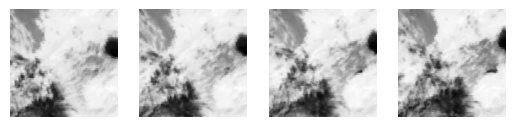

In [15]:
idx = 220

x0 = valid_ds[idx:idx+1].to(config.device)
print(x0.shape)
show_images(x0.squeeze())

In [16]:
describe(x0)

Image of type: <class 'torch.Tensor'>
data type:     torch.float32
shape:         torch.Size([1, 4, 128, 128])
min:           -0.4264844059944153
max:           0.3712269067764282



In [ ]:
preds = sample(model, x0[:,:-1,...])

In [ ]:
last_frame = preds[-1]
last_frame.shape

In [ ]:
describe(last_frame)

In [ ]:
show_image(last_frame.squeeze())

Compare!

In [ ]:
show_images(torch.cat([x0, x0[:,:-1], last_frame.to(x0.device)], dim=1).squeeze(), nrows=2)

In [ ]:
x0[:,-3:,...].shape

In [ ]:
def _sample_end(xt):
    "cut the array nd grabs last 3 frames"
    last_frame = sample(model, xt[:,-3:,...])[-1]
    return last_frame

In [ ]:
def sample_more(xt, n=1):
    "Autoregressive sampling"
    frames = xt
    for _ in progress_bar(range(n), total=n):
        new_frame = _sample_end(frames)
        frames = torch.cat([frames, new_frame.to(xt.device)], dim=1)
    return frames.cpu()

In [ ]:
N = 2

In [ ]:
frames = sample_more(x0, n=N)

Samples

In [ ]:
show_images(frames.squeeze(), figsize=(20,10))

GT

In [ ]:
show_images(valid_ds[idx:idx+4+N,0,...], figsize=(20,10))

In [ ]:
import numpy as np

def scale(arr):
    "Scales values of array in [0,1]"
    m, M = arr.min(), arr.max()
    return (arr - m) / (M - m)

def preprocess_frames(data):
    sdata = scale(data.squeeze())
    # print(sdata.shape)
    def tfm(frame):
        rframe = 255 * frame
        return rframe.cpu().numpy().astype(np.uint8)
    return [tfm(frame) for frame in sdata]

def to_video(data):
    "create wandb.Video container"
    frames = preprocess_frames(data)
    vid = np.stack(frames)[:, None, ...]
    return wandb.Video(vid)

## Log to wandb

In [ ]:
N = 7  # number of future frames
bs = 8 # how many samples

In [ ]:
import random

idxs = random.choices(range(len(valid_ds)-N), k=bs)  # select some samples
x0 = valid_ds[idxs].to(config.device)

In [ ]:
frames = sample_more(x0, N)

In [ ]:
i = 0
idx = idxs[i]
frames[i].shape, valid_ds[idx:idx+4+N,0,...].shape

In [ ]:
def htile(img):
    return torch.cat(img.split(1), dim=-1)

In [ ]:
def vtile(img):
    return torch.cat(img.split(1), dim=-2)

In [ ]:
show_image(htile(frames[i]))

In [ ]:
show_image(vtile(frames[i]))

In [ ]:
def vhtile(img1, img2):
    return vtile(torch.cat([htile(img1), htile(img2)], dim=0))

In [ ]:
show_image(vhtile(frames[i], valid_ds[idx:idx+4+N,0,...]), figsize=(20,5))

In [ ]:
table = wandb.Table(columns=["id", "gt", "gen", "gt/gen"])

In [ ]:
for i, idx in enumerate(idxs):
    pred_vid = to_video(frames[i])
    gt_vid = to_video(valid_ds[idx:idx+4+N,0,...])
    gt_gen = wandb.Image(vhtile(valid_ds[idx:idx+4+N,0,...], frames[i]))
    table.add_data(idx, gt_vid, pred_vid, gt_gen)

In [ ]:
with wandb.init(project="ddpm_clouds"):
    wandb.log({f"gen_table_{N}":table})